In [9]:
import tests.data as testdata
import tempfile

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import mllam_data_prep as mdp
import tests.data as testdata
from mllam_data_prep.ops import cropping    

In [10]:
tmpdir = tempfile.TemporaryDirectory()
l = 500 * 1.0e3  # length and width of domain in meters
config_lam = testdata.create_input_datasets_and_config(
    identifier="lam",
    data_categories=["state"],
    tmpdir=tmpdir,
    xlim=[-l/2.0, l/2.0],
    ylim=[-l/2.0, l/2.0],
)
# make the global domain twice as large as the LAM domain so that the lam
# domain is contained within the global domain
config_global = testdata.create_input_datasets_and_config(
    identifier="global",
    data_categories=["state"],
    tmpdir=tmpdir,
    xlim=[-l, l],
    ylim=[-l, l]
)


In [11]:
ds_lam = mdp.create_dataset(config=config_lam)
ds_global = mdp.create_dataset(config=config_global)

2024-12-10 17:02:17.477 | INFO     | mllam_data_prep.create_dataset:create_dataset:135 - Loading dataset lam_surface_analysis from /var/folders/n8/kcprfkd918967drydbc_bphw0000gr/T/tmp6h_c0_ze/lam/surface_analysis_ca45dbbf-5bbd-42f3-980f-55f6abe03466.zarr
2024-12-10 17:02:17.481 | INFO     | mllam_data_prep.create_dataset:create_dataset:160 - Mapping dimensions and variables for dataset lam_surface_analysis to state
2024-12-10 17:02:17.489 | INFO     | mllam_data_prep.create_dataset:_merge_dataarrays_by_target:48 - Merging dataarrays for target variable `state`
2024-12-10 17:02:17.499 | INFO     | mllam_data_prep.create_dataset:create_dataset:195 - Chunking dataset with {}
2024-12-10 17:02:17.500 | INFO     | mllam_data_prep.create_dataset:create_dataset:135 - Loading dataset global_surface_analysis from /var/folders/n8/kcprfkd918967drydbc_bphw0000gr/T/tmp6h_c0_ze/global/surface_analysis_c93d0634-bd93-4b36-9708-d180d7f57fe0.zarr
2024-12-10 17:02:17.510 | INFO     | mllam_data_prep.creat

In [12]:
ds_lam

<xarray.Dataset> Size: 5kB
Dimensions:                       (time: 5, grid_index: 80, state_feature: 1)
Coordinates:
  * time                          (time) datetime64[ns] 40B 2000-01-01 ... 20...
    x                             (grid_index) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    y                             (grid_index) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
  * state_feature                 (state_feature) <U15 60B 'pres_seasurface'
    state_feature_units           (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_long_name       (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_source_dataset  (state_feature) <U20 80B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: grid_index
Data variables:
    state                         (state_feature, time, grid_index) float64 3kB dask.array<chunksize=(1, 5, 80), meta=np.ndarray>
Attributes:
    schema_version:   v0.5.0
    dataset_version:  v0.1.0
    created_on:       2024-12-10T17:02:17
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    mdp_version:      v0.5.0

In [13]:
ds_global

<xarray.Dataset> Size: 5kB
Dimensions:                       (time: 5, grid_index: 80, state_feature: 1)
Coordinates:
  * time                          (time) datetime64[ns] 40B 2000-01-01 ... 20...
    x                             (grid_index) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    y                             (grid_index) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
  * state_feature                 (state_feature) <U15 60B 'pres_seasurface'
    state_feature_units           (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_long_name       (state_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state_feature_source_dataset  (state_feature) <U23 92B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: grid_index
Data variables:
    state                         (state_feature, time, grid_index) float64 3kB dask.array<chunksize=(1, 5, 80), meta=np.ndarray>
Attributes:
    schema_version:   v0.5.0
    dataset_version:  v0.1.0
    created_on:       2024-12-10T17:02:17
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    mdp_version:      v0.5.0

In [14]:
da_interior_mask = cropping.create_convex_hull_mask(ds=ds_global, ds_reference=ds_lam)

2024-12-10 17:02:17.553 | WARNING  | mllam_data_prep.ops.cropping:_add_latlon:30 - Could not find lat/lon coordinates. Assuming equal area projection centered on (lat, lon) = (0, 0) for now. This should be replaced!
2024-12-10 17:02:17.557 | WARNING  | mllam_data_prep.ops.cropping:_add_latlon:30 - Could not find lat/lon coordinates. Assuming equal area projection centered on (lat, lon) = (0, 0) for now. This should be replaced!


In [17]:
da_interior_mask = da_interior_mask.where(da_interior_mask, drop=True)

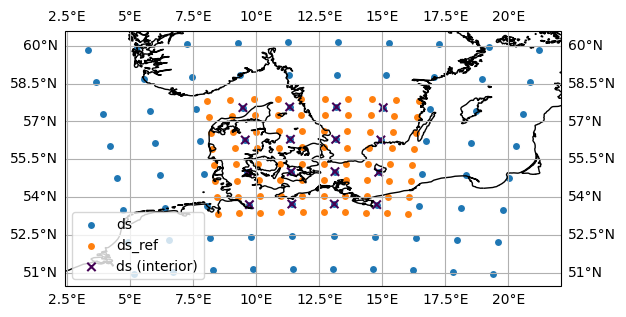

In [18]:
ds_reference = ds_lam
ds = ds_global

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
xr.plot.scatter(ax=ax, ds=ds, x="lon", y="lat", label="ds", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, ds=ds_reference, x="lon", y="lat", label="ds_ref", transform=ccrs.PlateCarree())
xr.plot.scatter(ax=ax, c=da_interior_mask, ds=da_interior_mask.to_dataset(name="mask"), x="lon", y="lat", marker="x", label="ds (interior)")
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.legend()
plt.show()
    

In [16]:

    
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs

    # fig, ax = plt.subplots()
    # xr.plot.scatter(ax=ax, ds=ds, x="x", y="y", label="ds")
    # xr.plot.scatter(ax=ax, ds=ds_reference, x="x", y="y", label="ds_ref")
    # xr.plot.scatter(ax=ax, ds=da_interior_mask.to_dataset(name="mask"), x="x", y="y", color="blue", label="mask")
    # ax.legend()
    # plt.show()